In [57]:
# read data
import pickle
import pandas as pd
import numpy as np
import networkx as nx

数据输入

In [58]:

# read pkl
with open('./data/scgpt_emb.pkl', 'rb') as f:
    scgpt_emb = pickle.load(f)

with open('./data/geneformer_gene_embs.pkl', 'rb') as f:
    geneformer_emb = pickle.load(f)

with open('./data/GenePT_gene_embedding_ada_text.pickle', 'rb') as f:
    genePT_emb = pickle.load(f)

with open('./data/gene_embeddings.pkl', 'rb') as f:
    gene_emb = pickle.load(f)

with open('./data/cell_embeddings_genePT-w.pkl', 'rb') as f:
    cell_emb = pickle.load(f)

# read protein_info.csv
protein_info = pd.read_csv('./data/protein_info.csv')

# read scgpt_gene2idx.txt
scgpt_gene2idx = pd.read_csv('./data/scgpt_gene2idx.txt', sep='\t', header=None)

# read ppi.csv
ppi = pd.read_csv('./data/ppi.csv')

# read gene_summary.csv
gene_info = pd.read_csv('./data/gene_summary.csv')

# read gene_expression.csv
gene_expression = pd.read_csv('./data/gene_expression.csv', index_col=0)

# read SLKB_rawSL.csv
sl_raw = pd.read_csv('./data/SLKB_rawSL.csv')


分析嵌入用的代码

In [59]:
# scgpt_emb类型输出
print(f'scgpt_emb type: {type(scgpt_emb)}')
# scgpt_emb长度输出
print(f'scgpt_emb length: {len(scgpt_emb)}')
# scgpt_emb元素长度输出
print(f'scgpt_emb[0] length: {len(next(iter(scgpt_emb.values())))}')
# scgpt_emb第一个元素输出
# print(f'scgpt_emb[0]: {next(iter(scgpt_emb.values()))}')

# geneformer_emb类型输出
print(f'geneformer_emb type: {type(geneformer_emb)}')
# geneformer_emb长度输出
print(f'geneformer_emb length: {len(geneformer_emb)}')
# geneformer_emb元素长度输出（这里默认选择其中一个实例进行输出）
# instance = next(iter(geneformer_emb.items()))
# print(f'geneformer_emb element length: {len(instance[1])}')  # instance[1]是真实embedding
# print(f'geneformer_emb example: {instance}')

# protein_info类型输出
print(f'protein_info type: {type(protein_info)}')
# protein_info长度输出
print(f'protein_info length: {len(protein_info)}')
# protein_info包含文件头
print(f'protein_info columns: {protein_info.columns}')
# protein_info示例输出
# print(f'protein_info example: {protein_info.head()}')

# ppi类型输出
print(f'ppi type: {type(ppi)}')
# ppi长度输出
print(f'ppi length: {len(ppi)}')
print("ppi is a adjacency List")
# ppi示例输出
# print(f'ppi example: {ppi.head()}')

# sl_raw类型输出
print(f'sl_raw type: {type(sl_raw)}')
# sl_raw长度输出
print(f'sl_raw length: {len(sl_raw)}')
# sl_raw包含文件头
print(f'sl_raw columns: {sl_raw.columns}')
# sl_raw示例输出
# print(f'sl_raw example: {sl_raw.head()}')

# gene_emb类型输出
print(f'gene_emb type: {type(gene_emb)}')
# gene_emb长度输出
print(f'gene_emb length: {len(gene_emb)}')
# gene_emb示例输出
# print(f'gene_emb example: {next(iter(gene_emb.items()))}')

# genePT_emb类型输出
print(f'genePT_emb type: {type(genePT_emb)}')
# genePT_emb长度输出
print(f'genePT_emb length: {len(genePT_emb)}')
# genePT_emb示例输出
# print(f'genePT_emb example: {next(iter(genePT_emb.items()))}')

# cell_emb类型输出
print(f'cell_emb type: {type(cell_emb)}')
# cell_emb长度输出
print(f'cell_emb length: {len(cell_emb)}')
# cell_emb示例输出
# print(f'cell_emb example: {next(iter(cell_emb.items()))}')

scgpt_emb type: <class 'dict'>
scgpt_emb length: 60697
scgpt_emb[0] length: 512
geneformer_emb type: <class 'dict'>
geneformer_emb length: 12550
protein_info type: <class 'pandas.core.frame.DataFrame'>
protein_info length: 9820
protein_info columns: Index(['Uniprot_entry_id', 'NCBI_gene_id', 'Protein names', 'Gene names',
       'Sequence'],
      dtype='object')
ppi type: <class 'pandas.core.frame.DataFrame'>
ppi length: 501299
ppi is a adjacency List
sl_raw type: <class 'pandas.core.frame.DataFrame'>
sl_raw length: 280483
sl_raw columns: Index(['Unnamed: 0', 'gene_pair', 'study_origin', 'cell_line_origin', 'gene_1',
       'gene_2', 'SL_or_not', 'SL_score', 'statistical_score',
       'SL_score_cutoff', 'statistical_score_cutoff'],
      dtype='object')
gene_emb type: <class 'dict'>
gene_emb length: 6096
genePT_emb type: <class 'dict'>
genePT_emb length: 93800
cell_emb type: <class 'dict'>
cell_emb length: 22


In [60]:
# 将 scgpt_gene2idx 的 '0' 列基因名称对应到 protein_info 的 Gene names 列
# 创建一个字典，将 scgpt_gene2idx 中的基因名映射到其索引
gene2idx_dict = dict(zip(scgpt_gene2idx[0], scgpt_gene2idx[1].astype(int)))
gene2name_dict = dict(zip(scgpt_gene2idx[1].astype(int), scgpt_gene2idx[0]))

# 提取 protein_info 中的基因名
# Gene names 列可能包含多个基因名，以空格分隔，我们需要处理这种情况
gene_names = protein_info['Gene names'].str.split().apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
protein_info['symbol'] = protein_info['Gene names'].str.split().apply(lambda x: x[0] if isinstance(x, list) and x else x)
# 将 protein_info 中的基因名映射到 scgpt_gene2idx 中的索引
mapped_ids = gene_names.map(gene2idx_dict)

# 添加映射成功的基因名和ID
protein_info['scGPT_id'] = mapped_ids.astype('Int64')  # 使用Int64类型支持NaN值
protein_info['scGPT_name'] = protein_info['scGPT_id'].map(gene2name_dict)

# 查看映射结果
print(f"成功映射的基因数量: {protein_info['scGPT_id'].notna().sum()}")
print(f"总基因数量: {len(protein_info)}")
print(f"映射成功率: {protein_info['scGPT_id'].notna().sum() / len(protein_info):.2%}")

# 构建模型分类头,预测合成致死
# 将NCBI_gene_id映射到scGPT_id
# 创建映射字典
protein_info['NCBI_gene_id'] = protein_info['NCBI_gene_id'].astype(str)
ncbi_to_scgpt = dict(zip(protein_info['NCBI_gene_id'], protein_info['scGPT_id']))
ncbi_to_symbol = dict(zip(protein_info['NCBI_gene_id'], protein_info['symbol']))
symbol_to_scgpt = dict(zip(protein_info["symbol"], protein_info["scGPT_id"]))

# 获取embedding维度
scgpt_dim = len(next(iter(scgpt_emb.values())))
gf_dim = len(next(iter(geneformer_emb.values())))

print(f"scgpt嵌入向量维度: {scgpt_dim}")
print(f"geneformer嵌入向量维度: {gf_dim}")

# 构建 PPI 图（基于基因符号）
# 将 PPI 中的 NCBI ID 转为符号
ppi['symA'] = ppi['geneA_ID'].map(ncbi_to_symbol)
ppi['symB'] = ppi['geneB_ID'].map(ncbi_to_symbol)
# 去除映射失败的行
ppi = ppi.dropna(subset=['symA','symB'])
print("过滤后PPI数据量:", len(ppi))
# 构建图
G = nx.from_pandas_edgelist(ppi, source='symA', target='symB', create_using=nx.Graph())

# 读取genePT_emb和gene_emb的嵌入维度
ge_dim = len(next(iter(gene_emb.values()))) if gene_emb else 0
gp_emb_dim = len(next(iter(genePT_emb.values()))) if genePT_emb else 0
cell_emb_dim = len(next(iter(cell_emb.values()))) if cell_emb else 0
print(f"gene嵌入向量维度: {ge_dim}")
print(f"genePT嵌入向量维度: {gp_emb_dim}")
print(f"cell line嵌入向量维度: {cell_emb_dim}")

# 将sl_train中的基因ID映射到scGPT_id
sl_raw = sl_raw.rename(columns={'gene_1': 'geneA_ID', 'gene_2': 'geneB_ID'})
sl_raw['SL_or_not'] = sl_raw['SL_or_not'].apply(lambda x: 1 if x == 'SL' else 0)
sl_raw = sl_raw.rename(columns={'SL_or_not': 'label'})
sl_raw['geneA_scGPT_id'] = sl_raw['geneA_ID'].map(symbol_to_scgpt)
sl_raw['geneB_scGPT_id'] = sl_raw['geneB_ID'].map(symbol_to_scgpt)

# 保留所有数据
sl_filtered = sl_raw.copy()
print(f"总数据量: {len(sl_filtered)}")
print(f"geneA映射缺失: {sl_filtered['geneA_scGPT_id'].isna().sum()}")
print(f"geneB映射缺失: {sl_filtered['geneB_scGPT_id'].isna().sum()}")

成功映射的基因数量: 9722
总基因数量: 9820
映射成功率: 99.00%
scgpt嵌入向量维度: 512
geneformer嵌入向量维度: 256
过滤后PPI数据量: 210031
gene嵌入向量维度: 768
genePT嵌入向量维度: 1536
cell line嵌入向量维度: 768
总数据量: 280483
geneA映射缺失: 42155
geneB映射缺失: 41735


In [61]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [62]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 输出设备信息
print(f"使用设备: {device}")

使用设备: cuda


In [63]:
# 生成节点特征
node_list = list(G.nodes())
node_to_idx = {node: i for i, node in enumerate(node_list)}
num_nodes = len(node_list)
edge_index = torch.tensor(
    [[node_to_idx[u] for u, v in G.edges()],
     [node_to_idx[v] for u, v in G.edges()]],
    dtype=torch.long
)

x_features = np.zeros((num_nodes, gf_dim), dtype=np.float32)
for i, node in enumerate(node_list):
    if node in geneformer_emb:
        x_features[i] = geneformer_emb[node]

# 创建PyTorch Geometric数据对象并移动到设备
data = Data(
    x=torch.from_numpy(x_features).to(device),
    edge_index=edge_index.to(device)
)

# 定义GCN模型
class PPIGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index)

# 初始化模型和优化器，并移动到设备
gnn = PPIGCN(gf_dim, 128, 64).to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)
sigmoid = torch.nn.Sigmoid()

# 无监督训练（示例使用随机游走负采样）
def train_gnn(model, data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model(data)
        
        # 正样本损失（现有边）
        pos_scores = sigmoid((z[data.edge_index[0]] * z[data.edge_index[1]]).sum(dim=1))
        pos_loss = -torch.log(pos_scores + 1e-15).mean()
        
        # 负采样
        neg_edges = torch.randint(0, data.num_nodes, (2, data.edge_index.size(1)), dtype=torch.long, device=device)
        neg_scores = sigmoid((z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1))
        neg_loss = -torch.log(1 - neg_scores + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_gnn(gnn, data, epochs=100)

# 生成最终节点嵌入
gnn.eval()
with torch.no_grad():
    node_embeddings = gnn(data).cpu().numpy()  # 将结果从 GPU 移动到 CPU

# 创建嵌入字典
ppi_embeddings = {node: node_embeddings[i] for i, node in enumerate(node_list)}

Epoch 0, Loss: 1.2021
Epoch 10, Loss: 1.2424
Epoch 20, Loss: 1.1673
Epoch 30, Loss: 1.1247
Epoch 40, Loss: 1.1044
Epoch 50, Loss: 1.0744
Epoch 60, Loss: 1.0736
Epoch 70, Loss: 1.0659
Epoch 80, Loss: 1.0545
Epoch 90, Loss: 1.0458


In [64]:
# 构建特征向量：将两个基因的embedding拼接
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc as auc_pr, balanced_accuracy_score
import matplotlib.pyplot as plt
import copy

In [65]:


# 获取特征向量，处理缺失的embedding
def get_gene_pair_features(df, is_train=True):
    features = []
    labels = [] if is_train else None
    
    for _, row in df.iterrows():
        # 原始特征
        a_idx = row['geneA_scGPT_id']
        b_idx = row['geneB_scGPT_id']
        symA = row['geneA_ID']
        symB = row['geneB_ID'] 
        cell_line_name = row['cell_line_origin']
        
        # 获取各嵌入向量
        scA = scgpt_emb.get(int(a_idx), np.zeros(scgpt_dim)) if not pd.isna(a_idx) else np.zeros(scgpt_dim)
        scB = scgpt_emb.get(int(b_idx), np.zeros(scgpt_dim)) if not pd.isna(b_idx) else np.zeros(scgpt_dim)
        gfA = geneformer_emb.get(symA, np.zeros(gf_dim))
        gfB = geneformer_emb.get(symB, np.zeros(gf_dim))
        geA = gene_emb.get(symA, np.zeros(ge_dim))
        geB = gene_emb.get(symB, np.zeros(ge_dim))
        cell_emb = genePT_emb.get(cell_line_name, np.zeros(cell_emb_dim))
        gpA = genePT_emb.get(symA, np.zeros(gp_emb_dim))
        gpB = genePT_emb.get(symB, np.zeros(gp_emb_dim))
        ppiA = ppi_embeddings.get(symA, np.zeros(64))
        ppiB = ppi_embeddings.get(symB, np.zeros(64))
        
        # 获取表达量特征
        try:
            exprA = gene_expression.loc[symA, cell_line_name]
        except KeyError:
            exprA = 0.0
        try:
            exprB = gene_expression.loc[symB, cell_line_name]
        except KeyError:
            exprB = 0.0
        expr_feats = np.array([exprA, exprB])
        
        # 拼接所有特征
        pair_feature = np.concatenate([
            scA, scB,          # scGPT (2*512)
            gfA, gfB,          # Geneformer (2*256)
            geA, geB,          # gene_emb (2*768)
            gpA, gpB,          # genePT emb (768)
            ppiA, ppiB,        # PPI嵌入 (2*64)
            cell_emb,          # cell line emb (768)      
            expr_feats         # 2
        ])
        features.append(pair_feature)
        if is_train:
            labels.append(row['label'])
    
    return (np.array(features), np.array(labels)) if is_train else np.array(features)

class SLClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.7),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.LeakyReLU(0.1), nn.Dropout(0.5),
        )
        self.attention = nn.Sequential(
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Softmax(dim=1)
        )
        self.sigmoid = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x): 
        x = self.net(x)
        att_weights = self.attention(x)
        x = att_weights * x
        return self.sigmoid(x).squeeze()

# 获取特征和标签
#features, labels = get_gene_pair_features(sl_filtered)

# 获取所有细胞系并划分
#all_cell_lines = sl_raw['cell_line_origin'].unique()


# 训练函数
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in data_loader:
        # 将数据移动到CUDA设备
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # 记录损失和预测
        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return total_loss / len(data_loader.dataset), acc, precision, recall, f1

# 验证函数
def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            # 将数据移动到CUDA设备
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    bacc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    try:
        auc_score = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc_score = 0.5
    
    metrics = {'loss': total_loss / len(data_loader.dataset), 'acc' : acc, 'bacc': bacc, 
               'precision': precision, 'recall' : recall,'f1': f1, 'auc': auc_score}
    
    return metrics, all_labels, all_probs

def balance_dataset(df, max_neg_ratio=3.0, min_pos_samples=5):

    pos_samples = df[df['label'] == 1]
    neg_samples = df[df['label'] == 0]
    
    n_pos = len(pos_samples)
    n_neg = len(neg_samples)
    
    # 确保最小正样本量
    if n_pos < min_pos_samples:
        return df  
    
    # 计算允许的最大负样本量
    max_allowed_neg = min(n_neg, int(n_pos * max_neg_ratio))
    
    # 随机采样负样本
    neg_sampled = neg_samples.sample(n=max_allowed_neg, random_state=42)

    # 如果 concatenation 后发现只有一类，也直接返回原 df
    if len(np.unique(pd.concat([pos_samples, neg_sampled])['label'])) < 2:
        return df
    
    return pd.concat([pos_samples, neg_sampled])

# 绘制训练曲线
def plot_training_curves(history, cell_line, fold_num):
    # 中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(12, 4))

    # 损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='训练损失')
    plt.plot(history['val_loss'], label='验证损失')
    plt.title(f'{cell_line} 第{fold_num}折损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='训练准确率')
    plt.plot(history['val_acc'], label='验证准确率')
    plt.title(f'{cell_line} 第{fold_num}折准确率')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # F1和AUC曲线
    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='训练F1')
    plt.plot(history['val_f1'], label='验证F1')
    plt.plot(history['val_auc'], label='验证AUC')
    plt.title(f'{cell_line} 第{fold_num}折F1/AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [66]:
'''
# 定义自编码器模型
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, bottleneck_dim),
            # nn.BatchNorm1d(bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(bottleneck_dim),
            nn.Linear(bottleneck_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, input_dim)
        )
    
    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return bottleneck, reconstructed
'''

'\n# 定义自编码器模型\nclass AutoEncoder(nn.Module):\n    def __init__(self, input_dim, bottleneck_dim):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.BatchNorm1d(input_dim),\n            nn.Linear(input_dim, 1024),\n            nn.LeakyReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(1024, 512),\n            nn.LeakyReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(512, bottleneck_dim),\n            # nn.BatchNorm1d(bottleneck_dim)\n        )\n        self.decoder = nn.Sequential(\n            nn.BatchNorm1d(bottleneck_dim),\n            nn.Linear(bottleneck_dim, 512),\n            nn.LeakyReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(512, 1024),\n            nn.LeakyReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(1024, input_dim)\n        )\n    \n    def forward(self, x):\n        bottleneck = self.encoder(x)\n        reconstructed = self.decoder(bottleneck)\n        return bottleneck, reconstructed\n'

In [67]:
from torch.optim.lr_scheduler import CosineAnnealingLR

class ImprovedAutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        # 编码器：渐进式降维
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3),  # 降低Dropout率
            
            # nn.Linear(1024, 512),
            # nn.BatchNorm1d(512),  # 添加中间层BN
            # nn.LeakyReLU(negative_slope=0.1),
            # nn.Dropout(0.3),
            
            nn.Linear(1024, bottleneck_dim),
            # nn.BatchNorm1d(bottleneck_dim),  # 启用瓶颈层BN
            # nn.Tanh()  # 约束输出范围
        )
        
        # 解码器：对称结构
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 1024),
            # nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3),
            
            # nn.Linear(512, 1024),
            # nn.BatchNorm1d(1024),
            # nn.LeakyReLU(negative_slope=0.1),
            # nn.Dropout(0.3),
            
            nn.Linear(1024, input_dim)
        )
    
    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return bottleneck, reconstructed

# 训练优化
def train_autoencoder(autoencoder, X_train, X_val, device, epochs=500, batch_size=512):
    # 将训练和验证数据转换为TensorDataset
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val))
    
    # 使用DataLoader分batch加载数据
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 使用MSE损失
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(autoencoder.parameters(), 
                                  lr=1e-3 , weight_decay=0)
    
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        autoencoder.train()
        epoch_loss = 0.0
        
        # 动态方差惩罚系数：从0线性增加到0.0001
        var_coeff = min(0.00001, 0.00001 * (epoch / 20))
        
        # 分batch训练
        for batch in train_loader:
            train_tensor = batch[0].to(device)
            
            # 前向传播
            bottleneck, reconstructed = autoencoder(train_tensor)
            
            # 损失计算
            recon_loss = criterion(reconstructed, train_tensor)
            var_loss = var_coeff * torch.mean(torch.var(bottleneck, dim=0))
            total_loss = recon_loss + var_loss
            
            # 反向传播优化
            optimizer.zero_grad()
            total_loss.backward()
            
            # 梯度裁剪（在optimizer.step之前）
            torch.nn.utils.clip_grad_norm_(
                autoencoder.parameters(), 
                max_norm=1.0,
                norm_type=2.0  # L2范数裁剪
            )
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        scheduler.step()
        
        # 验证集评估
        autoencoder.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_loader:
                val_tensor = val_batch[0].to(device)
                val_bottleneck, val_reconstructed = autoencoder(val_tensor)
                val_loss += criterion(val_reconstructed, val_tensor).item()
        
        val_loss /= len(val_loader)  # 计算平均验证损失
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
        
        # 打印训练信息
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_loss / len(train_loader):.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"LR: {scheduler.get_last_lr()[0]:.2e}")
    
    # 加载最佳模型
    autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))
    return autoencoder

In [68]:
def check_variance_preservation(original_data, encoded_data):
    """计算原始数据和编码数据的方差保留率"""
    # 原始数据总方差
    original_var = np.var(original_data, axis=0).sum()
    
    # 编码数据总方差
    encoded_var = np.var(encoded_data, axis=0).sum()
    
    # 保留率
    variance_ratio = encoded_var / original_var
    
    # PCA基准对比（保留相同维度）
    n_components = min(encoded_data.shape[1], original_data.shape[0], original_data.shape[1])
    pca = PCA(n_components=n_components)
    pca.fit(original_data)
    pca_var = np.var(pca.transform(original_data), axis=0).sum()
    
    print(f"原始数据总方差: {original_var:.2f}")
    print(f"编码数据总方差: {encoded_var:.2f} (保留率: {variance_ratio:.1%})")
    print(f"PCA同维度保留方差: {pca_var:.2f} (基准比例: {pca_var/original_var:.1%})")
    
    return variance_ratio

In [69]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_feature_space(original_data, encoded_data, labels=None):
    """对比原始数据和编码数据的特征分布"""
    plt.figure(figsize=(12, 5))
    
    # 原始数据可视化（降维到2D）
    plt.subplot(1, 2, 1)
    if original_data.shape[1] > 2:
        original_2d = TSNE(n_components=2).fit_transform(original_data)
    else:
        original_2d = original_data
    plt.scatter(original_2d[:, 0], original_2d[:, 1], c=labels, alpha=0.6)
    plt.title("Original Data Space")
    
    # 编码数据可视化
    plt.subplot(1, 2, 2)
    if encoded_data.shape[1] > 2:
        encoded_2d = TSNE(n_components=2).fit_transform(encoded_data)
    else:
        encoded_2d = encoded_data
    plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, alpha=0.6)
    plt.title("Encoded Feature Space")
    
    plt.tight_layout()
    plt.show()

In [70]:
class WeightedBCELoss(nn.Module):
    def __init__(self, neg_weight=1.0):
        super().__init__()
        self.neg_weight = neg_weight
        
    def forward(self, input, target):
        # 原始BCE损失
        loss = F.binary_cross_entropy(input, target, reduction='none')
        
        # 对负样本施加额外权重
        neg_mask = (target == 0).float()
        weighted_loss = loss * (1 + (self.neg_weight - 1) * neg_mask)
        
        return weighted_loss.mean()

In [71]:
from torch.utils.data import ConcatDataset
# 重采样正样本
def oversample_positive_samples(features, labels):
    positive_indices = [i for i, label in enumerate(labels) if label == 1]
    positive_features = features[positive_indices]
    positive_labels = [labels[i] for i in positive_indices]

    # 复制两份正样本
    oversampled_features = np.concatenate([positive_features] * 3, axis=0)
    oversampled_labels = positive_labels * 3

    # 合并原始数据和重采样数据
    features = np.concatenate([features, oversampled_features], axis=0)
    labels = np.concatenate([labels, oversampled_labels], axis=0)
    return features, labels


In [72]:
def cell_specific_cv(cell_line, df, n_splits=5):
    cell_data = df[df['cell_line_origin'] == cell_line].reset_index(drop=True)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_metrics = []
    fold_histories = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(cell_data, cell_data['label'])):
        if fold> 0:
            break
        
        print(f"\n=== 细胞系 {cell_line} 第 {fold+1} 折交叉验证 ===")
        # 数据划分
        tmp_fold = cell_data.iloc[train_idx].reset_index(drop=True) 
        test_fold = cell_data.iloc[test_idx].reset_index(drop=True)

        # 确保每个split至少有2个样本
        min_samples = 2
        if len(tmp_fold) < min_samples * 2:
            train_fold = tmp_fold
            val_fold = tmp_fold.sample(n=0, random_state=42)
        else:
            train_fold, val_fold = train_test_split(tmp_fold, test_size=0.15, stratify=tmp_fold['label'], random_state=42)
        
        # 平衡采样
        train_fold = balance_dataset(train_fold, max_neg_ratio=5.0)
        val_fold = balance_dataset(val_fold, max_neg_ratio=5.0)

        # 特征工程
        X_train, y_train = get_gene_pair_features(train_fold)
        X_val, y_val = get_gene_pair_features(val_fold)
        X_test, y_test = get_gene_pair_features(test_fold)

        print(f"特征维度: {X_train.shape[1]}")
        print(f"训练集: {X_train.shape[0]}")
        print(f"验证集: {X_val.shape[0]}") 
        print(f"测试集: {X_test.shape[0]}")

        # 修改后的训练和特征提取流程
        bottleneck_dim = 256
        input_dim = X_train.shape[1]

        # 2. 初始化改进版模型
        autoencoder = ImprovedAutoEncoder(input_dim, bottleneck_dim).to(device)

        # 3. 训练（使用改进的训练函数）
        # trained_ae_train = train_autoencoder(autoencoder, X_train, X_val, device, epochs=500)
        # trained_ae_val = train_autoencoder(autoencoder, X_val, X_val, device, epochs=150)
        
        # 将训练、验证和测试集从 numpy 转换为 PyTorch Tensor
        X_train_tensor = torch.FloatTensor(X_train)
        X_val_tensor = torch.FloatTensor(X_val)
        # X_test_tensor = torch.FloatTensor(X_test)

        # 拼接训练、验证和测试集
        full_dataset = torch.cat((X_train_tensor, X_val_tensor), dim=0)

        # 使用全数据集训练自编码器
        trained_ae_full = train_autoencoder(autoencoder, full_dataset, full_dataset, device, epochs=500)

        # 4. 特征提取与诊断
        autoencoder.eval()
        with torch.no_grad():
            # 分别处理三个数据集
            X_train_bottleneck = autoencoder.encoder(torch.FloatTensor(X_train).to(device)).cpu().numpy()
            X_val_bottleneck = autoencoder.encoder(torch.FloatTensor(X_val).to(device)).cpu().numpy()
            X_test_bottleneck = autoencoder.encoder(torch.FloatTensor(X_test).to(device)).cpu().numpy()

            # 诊断分析（仅用训练集）
            check_variance_preservation(X_train, X_train_bottleneck)
            print("零方差维度数量:", np.sum(np.var(X_train_bottleneck, axis=0) < 1e-6))
            
            # 检查各数据集维度匹配
            print(f"训练集特征: {X_train_bottleneck.shape}, 标签: {len(y_train)}")
            print(f"验证集特征: {X_val_bottleneck.shape}, 标签: {len(y_val)}")
            print(f"测试集特征: {X_test_bottleneck.shape}, 标签: {len(y_test)}")
        
        # 5. 创建PyTorch数据集
        def create_tensor_dataset(features, labels):
            features_tensor = torch.FloatTensor(features).to(device)
            labels_tensor = torch.FloatTensor(labels).to(device)
            return TensorDataset(features_tensor, labels_tensor)
        '''
        train_dataset = create_tensor_dataset(X_train_bottleneck, y_train)
        val_dataset = create_tensor_dataset(X_val_bottleneck, y_val)
        test_dataset = create_tensor_dataset(X_test_bottleneck, y_test)
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_dataset)))
        '''
        # 对训练集进行重采样
        X_train_resampled, y_train_resampled = oversample_positive_samples(X_train_bottleneck, y_train)

        # 创建PyTorch数据集
        train_dataset = create_tensor_dataset(X_train_resampled, y_train_resampled)
        val_dataset = create_tensor_dataset(X_val_bottleneck, y_val)
        test_dataset = create_tensor_dataset(X_test_bottleneck, y_test)

        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_dataset)))

        # 输入向量维度
        input_dim = X_train_bottleneck.shape[1]
        print(f"输入向量维度: {input_dim}")
        
        # 初始化模型并移动到GPU
        model = SLClassifier(input_dim=input_dim).to(device)
        
        # criterion = nn.BCELoss()
        criterion = WeightedBCELoss(neg_weight=10.0)  # 可以调整neg_weight值

        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # 训练参数
        best_loss = float('inf')
        best_model = None
        patience = 100
        counter = 0
        fold_history = {
            'train_loss': [], 'train_acc': [], 'train_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
        }
        epochs_main = 500
        # 训练循环
        for epoch in range(epochs_main):
            # 训练步骤
            train_loss, train_acc, _, _, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
            
            # 验证步骤（使用部分训练数据）
            val_metrics, _, _ = validate(model, val_loader, criterion)
            
            # 记录历史
            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['train_f1'].append(train_f1)
            fold_history['val_loss'].append(val_metrics['loss'])
            fold_history['val_acc'].append(val_metrics['acc'])
            fold_history['val_f1'].append(val_metrics['f1'])
            fold_history['val_auc'].append(val_metrics['auc'])
            
            # 打印进度
            print(f"Epoch {epoch+1}/{epochs_main} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f} | Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
            
            # 早停逻辑
            if val_metrics['loss'] < best_loss:
                best_loss = val_metrics['loss']
                best_model = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            scheduler.step(val_metrics['loss'])
            
        fold_histories.append(fold_history)

        # 评估模型
        model.load_state_dict(best_model)
        test_metrics, _, _ = validate(model, test_loader, criterion)
        fold_metrics.append(test_metrics)

    return fold_metrics, fold_histories

In [73]:
'''
def cell_specific_cv(cell_line, df, n_splits=5):
    cell_data = df[df['cell_line_origin'] == cell_line].reset_index(drop=True)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_metrics = []
    fold_histories = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(cell_data, cell_data['label'])):
        print(f"\n=== 细胞系 {cell_line} 第 {fold+1} 折交叉验证 ===")
        # 数据划分
        tmp_fold = cell_data.iloc[train_idx].reset_index(drop=True) 
        test_fold = cell_data.iloc[test_idx].reset_index(drop=True)

        # 确保每个split至少有2个样本
        min_samples = 2
        if len(tmp_fold) < min_samples * 2:
            train_fold = tmp_fold
            val_fold = tmp_fold.sample(n=0, random_state=42)
        else:
            train_fold, val_fold = train_test_split(tmp_fold, test_size=0.15, stratify=tmp_fold['label'], random_state=42)
        
        # 平衡采样
        train_fold = balance_dataset(train_fold, max_neg_ratio=5.0)
        val_fold = balance_dataset(val_fold, max_neg_ratio=5.0)

        # 特征工程
        X_train, y_train = get_gene_pair_features(train_fold)
        X_val, y_val = get_gene_pair_features(val_fold)
        X_test, y_test = get_gene_pair_features(test_fold)

        print(f"特征维度: {X_train.shape[1]}")
        print(f"训练集: {X_train.shape[0]}")
        print(f"验证集: {X_val.shape[0]}") 
        print(f"测试集: {X_test.shape[0]}")

        bottleneck_dim= 256
        
        input_dim = X_train.shape[1]
        autoencoder = AutoEncoder(input_dim, bottleneck_dim).to(device)
        criterion_ae = nn.MSELoss()
        optimizer_ae = optim.Adam(autoencoder.parameters(), lr=1e-3)

        # 自监督训练自编码器
        train_tensor = torch.FloatTensor(X_train).to(device)
        epochs = 100
        
        for epoch in range(epochs):
            autoencoder.train()
            bottleneck, reconstructed = autoencoder(train_tensor)
            loss = criterion_ae(reconstructed, train_tensor) + 0.0001 * torch.mean(torch.var(bottleneck, dim=0))
            
            optimizer_ae.zero_grad()
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
            optimizer_ae.step()
            
            if epoch % 10 == 0:
                print(f"AutoEncoder Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        # 提取瓶颈层特征
        autoencoder.eval()
        with torch.no_grad():
            X_train_bottleneck = autoencoder.encoder(torch.FloatTensor(X_train).to(device)).cpu().numpy()
            X_val_bottleneck = autoencoder.encoder(torch.FloatTensor(X_val).to(device)).cpu().numpy()
            X_test_bottleneck = autoencoder.encoder(torch.FloatTensor(X_test).to(device)).cpu().numpy()

            # 原始数据（需与encoded_data样本顺序一致）
            original_data = np.vstack([X_train, X_val, X_test])
            
            # 执行诊断
            check_variance_preservation(original_data, X_train_bottleneck)
            # visualize_feature_space(original_data, X_train_bottleneck)
            
            # 检查是否有崩溃维度
            print("零方差维度数量:", np.sum(np.var(X_train_bottleneck, axis=0) < 1e-6))

        # 创建数据集
        train_dataset = TensorDataset(torch.FloatTensor(X_train_bottleneck).to(device), torch.FloatTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.FloatTensor(X_val_bottleneck).to(device), torch.FloatTensor(y_val).to(device))
        test_dataset = TensorDataset(torch.FloatTensor(X_test_bottleneck).to(device), torch.FloatTensor(y_test).to(device))
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_dataset)))

        # 输入向量维度
        input_dim = X_train_bottleneck.shape[1]
        print(f"输入向量维度: {input_dim}")
        
        # 初始化模型并移动到GPU
        model = SLClassifier(input_dim=input_dim).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # 训练参数
        best_loss = float('inf')
        best_model = None
        patience = 10
        counter = 0
        fold_history = {
            'train_loss': [], 'train_acc': [], 'train_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
        }
        epochs_main = 500
        # 训练循环
        for epoch in range(epochs_main):
            # 训练步骤
            train_loss, train_acc, _, _, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
            
            # 验证步骤（使用部分训练数据）
            val_metrics, _, _ = validate(model, val_loader, criterion)
            
            # 记录历史
            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['train_f1'].append(train_f1)
            fold_history['val_loss'].append(val_metrics['loss'])
            fold_history['val_acc'].append(val_metrics['acc'])
            fold_history['val_f1'].append(val_metrics['f1'])
            fold_history['val_auc'].append(val_metrics['auc'])
            
            # 打印进度
            print(f"Epoch {epoch+1}/{epochs_main} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f} | Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
            
            # 早停逻辑
            if val_metrics['loss'] < best_loss:
                best_loss = val_metrics['loss']
                best_model = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            scheduler.step(val_metrics['loss'])
            
        fold_histories.append(fold_history)

        # 评估模型
        model.load_state_dict(best_model)
        test_metrics, _, _ = validate(model, test_loader, criterion)
        fold_metrics.append(test_metrics)

    return fold_metrics, fold_histories
'''

'\ndef cell_specific_cv(cell_line, df, n_splits=5):\n    cell_data = df[df[\'cell_line_origin\'] == cell_line].reset_index(drop=True)\n    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)\n    \n    fold_metrics = []\n    fold_histories = []\n    \n    for fold, (train_idx, test_idx) in enumerate(skf.split(cell_data, cell_data[\'label\'])):\n        print(f"\n=== 细胞系 {cell_line} 第 {fold+1} 折交叉验证 ===")\n        # 数据划分\n        tmp_fold = cell_data.iloc[train_idx].reset_index(drop=True) \n        test_fold = cell_data.iloc[test_idx].reset_index(drop=True)\n\n        # 确保每个split至少有2个样本\n        min_samples = 2\n        if len(tmp_fold) < min_samples * 2:\n            train_fold = tmp_fold\n            val_fold = tmp_fold.sample(n=0, random_state=42)\n        else:\n            train_fold, val_fold = train_test_split(tmp_fold, test_size=0.15, stratify=tmp_fold[\'label\'], random_state=42)\n        \n        # 平衡采样\n        train_fold = balance_dataset(train_fold, max

In [74]:
final_results = {}
all_histories = {}
cell_line_data = sl_filtered['cell_line_origin'].unique()
print("可用的细胞系：", cell_line_data)

# 只处理目标细胞系
target_cell_lines = ['RPE1', 'K562', '22RV1','HSC5']
for cell_line in cell_line_data:
    if cell_line in target_cell_lines:
        metrics, histories = cell_specific_cv(cell_line, sl_filtered)
        final_results[cell_line] = {
            'loss': np.mean([m['loss'] for m in metrics]),
            'acc': np.mean([m['acc'] for m in metrics]),
            'auc': np.mean([m['auc'] for m in metrics]),
            'precision': np.mean([m['precision'] for m in metrics]),
            'recall': np.mean([m['recall'] for m in metrics]),
            'f1': np.mean([m['f1'] for m in metrics]),
            'bacc': np.mean([m['bacc'] for m in metrics])
        }
        all_histories[cell_line] = histories

可用的细胞系： ['RPE1' 'K562' 'JURKAT' 'A549' 'GI1' 'HS936T' 'HS944T' 'HSC5' 'IPC298'
 'MEL202' 'MELJUSO' 'MEWO' 'PATU8988S' 'PK1' 'PC9' 'HELA' '293T' 'A375'
 'OVCAR8' '22RV1' 'HT29' '786O']

=== 细胞系 RPE1 第 1 折交叉验证 ===
特征维度: 7042
训练集: 8098
验证集: 1430
测试集: 2383
Epoch 1/500 | Train Loss: 8.1650 | Val Loss: 7.5276 | LR: 1.00e-03
Epoch 11/500 | Train Loss: 0.2324 | Val Loss: 0.1558 | LR: 9.99e-04
Epoch 21/500 | Train Loss: 0.1463 | Val Loss: 0.1036 | LR: 9.96e-04
Epoch 31/500 | Train Loss: 0.1096 | Val Loss: 0.0552 | LR: 9.91e-04
Epoch 41/500 | Train Loss: 0.0909 | Val Loss: 0.0437 | LR: 9.84e-04
Epoch 51/500 | Train Loss: 0.0841 | Val Loss: 0.0342 | LR: 9.75e-04
Epoch 61/500 | Train Loss: 0.0755 | Val Loss: 0.0329 | LR: 9.64e-04
Epoch 71/500 | Train Loss: 0.0700 | Val Loss: 0.0290 | LR: 9.51e-04
Epoch 81/500 | Train Loss: 0.0674 | Val Loss: 0.0271 | LR: 9.37e-04
Epoch 91/500 | Train Loss: 0.0648 | Val Loss: 0.0296 | LR: 9.20e-04
Epoch 101/500 | Train Loss: 0.0647 | Val Loss: 0.0263 | LR: 9.03e-04

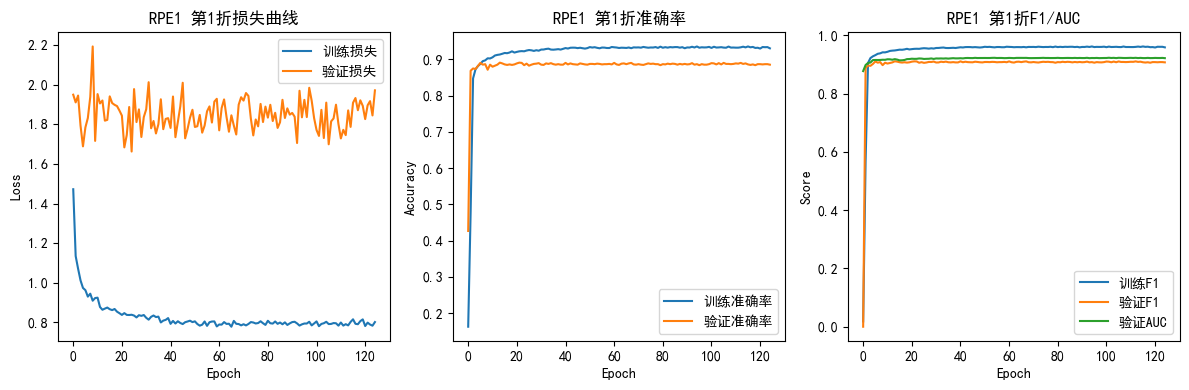

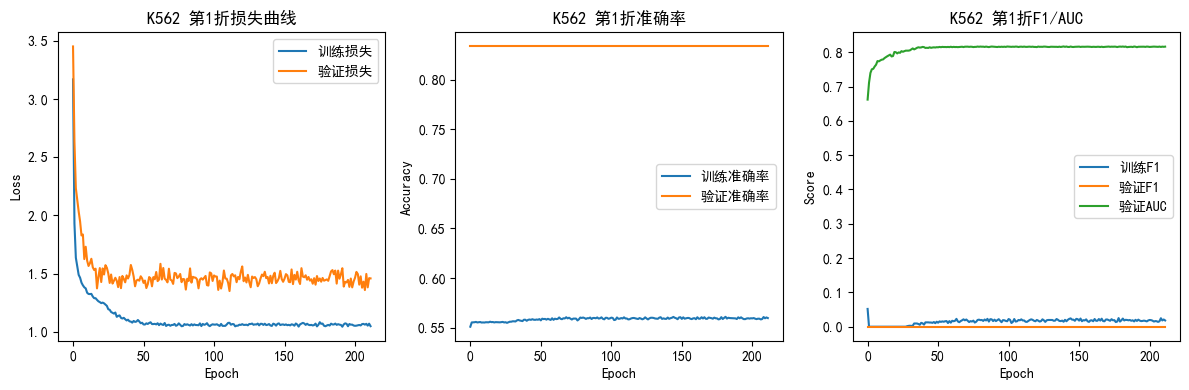

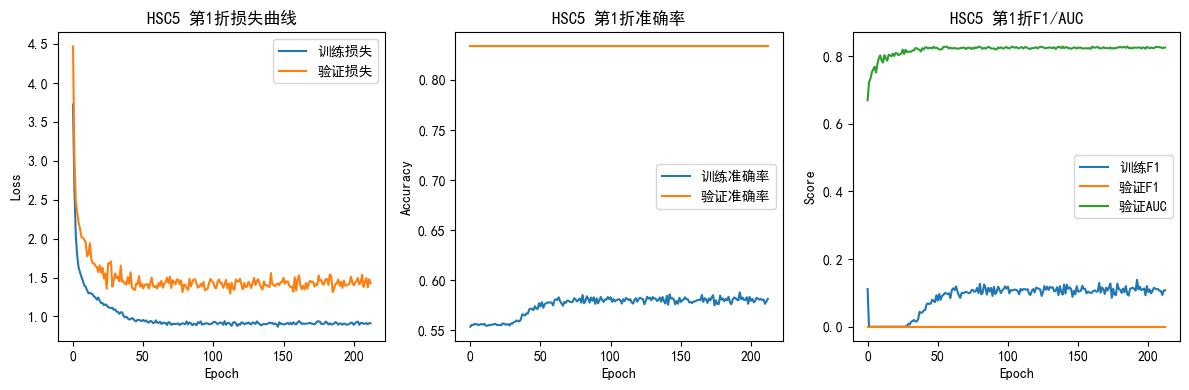

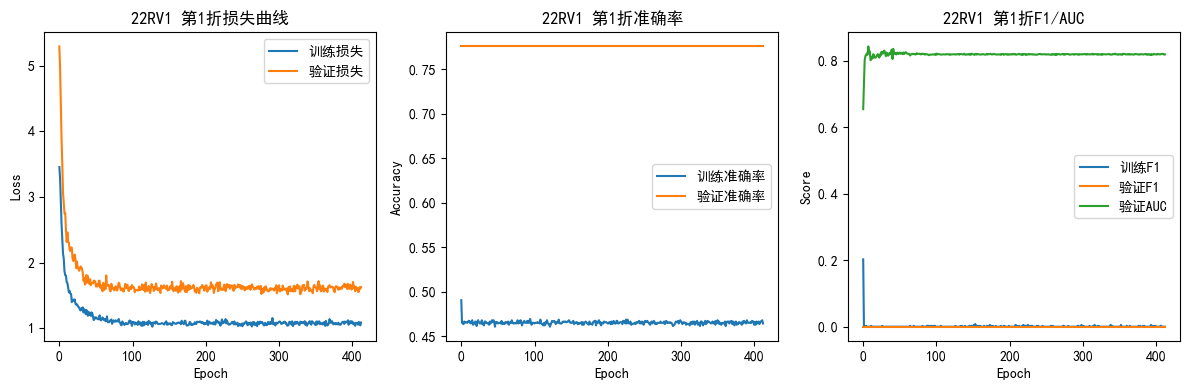

RPE1:
  Loss: 1.7304  Accuracy: 0.8825
  AUC: 0.9141  Precision: 0.8513  Recall: 0.9634
  F1: 0.9039  BACC: 0.8685
K562:
  Loss: 1.3022  Accuracy: 0.9871
  AUC: 0.8172  Precision: 0.0000  Recall: 0.0000
  F1: 0.0000  BACC: 0.5000
HSC5:
  Loss: 1.3502  Accuracy: 0.8549
  AUC: 0.8078  Precision: 0.0000  Recall: 0.0000
  F1: 0.0000  BACC: 0.5000
22RV1:
  Loss: 1.6414  Accuracy: 0.7755
  AUC: 0.7874  Precision: 0.0000  Recall: 0.0000
  F1: 0.0000  BACC: 0.5000


In [75]:
# 训练历史
for cell_line in all_histories:
    if len(all_histories[cell_line]) > 0:
        first_fold_history = all_histories[cell_line][0]
        plot_training_curves(first_fold_history, cell_line, 1)
        
# 测试集结果
for cell_line, metrics in final_results.items():
    print(f"{cell_line}:")
    print(f"  Loss: {metrics['loss']:.4f}  Accuracy: {metrics['acc']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}  Precision: {metrics['precision']:.4f}  Recall: {metrics['recall']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}  BACC: {metrics['bacc']:.4f}")

In [38]:
# 定义消融实验配置
ABLATION_CONFIGS = {
    "all_features": {"scgpt": True, "geneformer": True, "gene_emb": True, 
                    "genePT": True, "ppi": True, "cell_emb": True, "expr": True},
    "no_scgpt": {"scgpt": False, "geneformer": True, "gene_emb": True, 
                "genePT": True, "ppi": True, "cell_emb": True, "expr": True},
    "no_geneformer": {"scgpt": True, "geneformer": False, "gene_emb": True, 
                     "genePT": True, "ppi": True, "cell_emb": True, "expr": True},
    "no_gene_emb": {"scgpt": True, "geneformer": True, "gene_emb": False, 
                   "genePT": True, "ppi": True, "cell_emb": True, "expr": True},
    "no_genePT": {"scgpt": True, "geneformer": True, "gene_emb": True, 
                 "genePT": False, "ppi": True, "cell_emb": True, "expr": True},
    "no_ppi": {"scgpt": True, "geneformer": True, "gene_emb": True, 
              "genePT": True, "ppi": False, "cell_emb": True, "expr": True},
    "no_cell_emb": {"scgpt": True, "geneformer": True, "gene_emb": True, 
                   "genePT": True, "ppi": True, "cell_emb": False, "expr": True},
    "no_expr": {"scgpt": True, "geneformer": True, "gene_emb": True, 
               "genePT": True, "ppi": True, "cell_emb": True, "expr": False},
}

# 修改后的特征提取函数（支持消融配置）
def get_gene_pair_features_ablation(df, ablation_cfg, is_train=True):
    features = []
    labels = [] if is_train else None
    
    for _, row in df.iterrows():
        a_idx = row['geneA_scGPT_id']
        b_idx = row['geneB_scGPT_id']
        symA = row['geneA_ID']
        symB = row['geneB_ID'] 
        cell_line_name = row['cell_line_origin']
        
        # 根据消融配置获取特征
        feature_parts = []
        
        # scGPT特征
        if ablation_cfg['scgpt']:
            scA = scgpt_emb.get(int(a_idx), np.zeros(scgpt_dim)) if not pd.isna(a_idx) else np.zeros(scgpt_dim)
            scB = scgpt_emb.get(int(b_idx), np.zeros(scgpt_dim)) if not pd.isna(b_idx) else np.zeros(scgpt_dim)
            feature_parts.extend([scA, scB])
        
        # Geneformer特征
        if ablation_cfg['geneformer']:
            gfA = geneformer_emb.get(symA, np.zeros(gf_dim))
            gfB = geneformer_emb.get(symB, np.zeros(gf_dim))
            feature_parts.extend([gfA, gfB])
        
        # Gene Embedding特征
        if ablation_cfg['gene_emb']:
            geA = gene_emb.get(symA, np.zeros(ge_dim))
            geB = gene_emb.get(symB, np.zeros(ge_dim))
            feature_parts.extend([geA, geB])
        
        # GenePT特征
        if ablation_cfg['genePT']:
            gpA = genePT_emb.get(symA, np.zeros(gp_emb_dim))
            gpB = genePT_emb.get(symB, np.zeros(gp_emb_dim))
            feature_parts.extend([gpA, gpB])
        
        # PPI特征
        if ablation_cfg['ppi']:
            ppiA = ppi_embeddings.get(symA, np.zeros(64))
            ppiB = ppi_embeddings.get(symB, np.zeros(64))
            feature_parts.extend([ppiA, ppiB])
        
        # 细胞系嵌入
        if ablation_cfg['cell_emb']:
            cell_emb = genePT_emb.get(cell_line_name, np.zeros(cell_emb_dim))
            feature_parts.append(cell_emb)
        
        # 表达量特征
        if ablation_cfg['expr']:
            try:
                exprA = gene_expression.loc[symA, cell_line_name]
            except KeyError:
                exprA = 0.0
            try:
                exprB = gene_expression.loc[symB, cell_line_name]
            except KeyError:
                exprB = 0.0
            expr_feats = np.array([exprA, exprB])
            feature_parts.append(expr_feats)
        
        # 拼接所有保留的特征
        pair_feature = np.concatenate(feature_parts)
        features.append(pair_feature)
        
        if is_train:
            labels.append(row['label'])
    
    return (np.array(features), np.array(labels)) if is_train else np.array(features)

def ablation_study(cell_line, df, n_splits=5):
    results = {}
    
    for config_name, ablation_cfg in ABLATION_CONFIGS.items():
        print(f"\n=== 开始消融实验: {config_name} ===")
        print(f"特征配置: {ablation_cfg}")
        
        cell_data = df[df['cell_line_origin'] == cell_line].reset_index(drop=True)
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        fold_metrics = []
        fold_histories = []
        
        for fold, (train_idx, test_idx) in enumerate(skf.split(cell_data, cell_data['label'])):
            print(f"\n=== 细胞系 {cell_line} | 配置 {config_name} | 第 {fold+1} 折交叉验证 ===")
            
            # 数据划分
            tmp_fold = cell_data.iloc[train_idx].reset_index(drop=True) 
            test_fold = cell_data.iloc[test_idx].reset_index(drop=True)

            min_samples = 2
            if len(tmp_fold) < min_samples * 2:
                train_fold = tmp_fold
                val_fold = tmp_fold.sample(n=0, random_state=42)
            else:
                train_fold, val_fold = train_test_split(
                    tmp_fold, test_size=0.15, stratify=tmp_fold['label'], random_state=42
                )
            
            # 平衡采样
            train_fold = balance_dataset(train_fold, max_neg_ratio=5.0)
            val_fold = balance_dataset(val_fold, max_neg_ratio=5.0)

            # 使用当前消融配置提取特征
            X_train, y_train = get_gene_pair_features(train_fold, ablation_cfg)
            X_val, y_val = get_gene_pair_features(val_fold, ablation_cfg)
            X_test, y_test = get_gene_pair_features(test_fold, ablation_cfg)

            print(f"特征维度: {X_train.shape[1]}")
            print(f"训练集: {X_train.shape[0]}")
            print(f"验证集: {X_val.shape[0]}") 
            print(f"测试集: {X_test.shape[0]}")
            
            # 数据预处理
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test = scaler.transform(X_test)
            
            pca = PCA(n_components=0.95)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val_scaled)
            X_test = pca.transform(X_test)

            print(f"降维后特征维度: {X_train.shape[1]}")
            print(f"累计解释方差: {np.sum(pca.explained_variance_ratio_):.2%}")

            # 转换为张量
            train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
            val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
            test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
            
            # 创建数据加载器
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
            val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_dataset)))
            test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_dataset)))
            
            # 初始化模型
            model = SLClassifier(X_train.shape[1])
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

            # 训练参数
            best_loss = float('inf')
            best_model = None
            patience = 10
            counter = 0
            fold_history = {
                'train_loss': [], 'train_acc': [], 'train_f1': [],
                'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
            }
            
            # 训练循环
            for epoch in range(100):
                train_loss, train_acc, _, _, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
                val_metrics, _, _ = validate(model, val_loader, criterion)
                
                fold_history['train_loss'].append(train_loss)
                fold_history['train_acc'].append(train_acc)
                fold_history['train_f1'].append(train_f1)
                fold_history['val_loss'].append(val_metrics['loss'])
                fold_history['val_acc'].append(val_metrics['acc'])
                fold_history['val_f1'].append(val_metrics['f1'])
                fold_history['val_auc'].append(val_metrics['auc'])
                
                print(f"Epoch {epoch+1}/100 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f} | Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
                
                if val_metrics['loss'] < best_loss:
                    best_loss = val_metrics['loss']
                    best_model = copy.deepcopy(model.state_dict())
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
                
                # scheduler.step(val_metrics['loss'])
            
            fold_histories.append(fold_history)

            # 评估模型
            model.load_state_dict(best_model)
            test_metrics, _, _ = validate(model, test_loader, criterion)
            fold_metrics.append(test_metrics)
        
        # 保存当前配置的结果
        results[config_name] = {
            'fold_metrics': fold_metrics,
            'fold_histories': fold_histories
        }
    
    return results

# 选择要分析的细胞系
target_cell_line = "K562"

# 运行消融实验
ablation_results = ablation_study(target_cell_line, sl_filtered)

# 分析并展示结果
print("\n=== 消融实验结果汇总 ===")
for config, result in ablation_results.items():
    fold_metrics = result['fold_metrics']
    # 计算平均指标
    avg_auc = np.mean([m['auc'] for m in fold_metrics])
    avg_f1 = np.mean([m['f1'] for m in fold_metrics])
    avg_acc = np.mean([m['acc'] for m in fold_metrics])
    print(f"{config}: AUC={avg_auc:.4f}, F1={avg_f1:.4f}, Acc={avg_acc:.4f}")




=== 开始消融实验: all_features ===
特征配置: {'scgpt': True, 'geneformer': True, 'gene_emb': True, 'genePT': True, 'ppi': True, 'cell_emb': True, 'expr': True}

=== 细胞系 K562 | 配置 all_features | 第 1 折交叉验证 ===
特征维度: 7042
训练集: 6372
验证集: 1128
测试集: 24184
降维后特征维度: 651
累计解释方差: 95.01%
Epoch 1/100 | Train Loss: 0.6063 | Train Acc: 0.8193
Val Loss: 0.5445 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: 0.7446
Epoch 2/100 | Train Loss: 0.4747 | Train Acc: 0.8334
Val Loss: 0.4784 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: 0.7918
Epoch 3/100 | Train Loss: 0.4230 | Train Acc: 0.8332
Val Loss: 0.4489 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: 0.8108
Epoch 4/100 | Train Loss: 0.3955 | Train Acc: 0.8335
Val Loss: 0.4311 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: 0.8249
Epoch 5/100 | Train Loss: 0.3721 | Train Acc: 0.8334
Val Loss: 0.4199 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: 0.8326
Epoch 6/100 | Train Loss: 0.3570 | Train Acc: 0.8332
Val Loss: 0.4084 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: 

In [17]:
# 跨细胞系预测
def cross_cellline_eval(train_cells, test_cell, df):
    # 数据准备
    train_df = df[df['cell_line_origin'].isin(train_cells)]
    test_df = df[df['cell_line_origin'] == test_cell]
    
    # 划分训练集和验证集
    min_samples = 2
    if len(train_df) < min_samples * 2:
        train_fold = train_df
        val_fold = train_df.sample(n=0, random_state=42)
    else:
        train_fold, val_fold = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)
    
    # 特征工程
    X_train, y_train = get_gene_pair_features(train_fold)
    X_val, y_val = get_gene_pair_features(val_fold)
    X_test, y_test = get_gene_pair_features(test_df)

    print(f"特征维度: {X_train.shape[1]}")
    print(f"训练集: {X_train.shape[0]}")
    print(f"验证集: {X_val.shape[0]}") 
    print(f"测试集: {X_test.shape[0]}")
    
    # 数据预处理
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    pca = PCA(n_components=0.95)
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

    print(f"降维后特征维度: {X_train.shape[1]}")
    print(f"累计解释方差: {np.sum(pca.explained_variance_ratio_):.2%}")
    
    # 转换为张量
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_dataset)))
    test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_dataset)))
    
    # 初始化模型
    model = SLClassifier(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # 训练参数
    best_loss = float('inf')
    best_model = None
    counter = 0
    train_history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }
    
    # 训练循环
    for epoch in range(100):
        # 训练步骤
        train_loss, train_acc, _, _, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
        
        # 验证步骤
        val_metrics, _, _ = validate(model, val_loader, criterion)
        
        # 记录历史
        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        train_history['train_f1'].append(train_f1)
        train_history['val_loss'].append(val_metrics['loss'])
        train_history['val_acc'].append(val_metrics['acc'])
        train_history['val_f1'].append(val_metrics['f1'])
        train_history['val_auc'].append(val_metrics['auc'])
        
        # 打印进度
        print(f"Epoch {epoch+1}/100 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
        
        # 早停逻辑
        if val_metrics['loss'] < best_loss:
            best_loss = val_metrics['loss']
            best_model = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= 10:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # 加载最佳模型
    model.load_state_dict(best_model)
    
    # 最终测试评估
    test_metrics, _, _ = validate(model, test_loader, criterion)
    
    return {
        'test_metrics': test_metrics,
        'train_history': train_history
    }

特征维度: 7042
训练集: 14254
验证集: 2516
测试集: 9062
降维后特征维度: 892
累计解释方差: 95.01%
Epoch 1/100 | Train Loss: 0.5054 | Train Acc: 0.7578
Val Loss: 0.3207 | Val Acc: 0.8867 | Val AUC: 0.9300
Epoch 2/100 | Train Loss: 0.3571 | Train Acc: 0.8647
Val Loss: 0.3061 | Val Acc: 0.8895 | Val AUC: 0.9343
Epoch 3/100 | Train Loss: 0.3396 | Train Acc: 0.8717
Val Loss: 0.3056 | Val Acc: 0.8911 | Val AUC: 0.9367
Epoch 4/100 | Train Loss: 0.3227 | Train Acc: 0.8774
Val Loss: 0.3036 | Val Acc: 0.8935 | Val AUC: 0.9376
Epoch 5/100 | Train Loss: 0.3163 | Train Acc: 0.8803
Val Loss: 0.2980 | Val Acc: 0.8951 | Val AUC: 0.9387
Epoch 6/100 | Train Loss: 0.3040 | Train Acc: 0.8828
Val Loss: 0.2982 | Val Acc: 0.8959 | Val AUC: 0.9396
Epoch 7/100 | Train Loss: 0.2995 | Train Acc: 0.8841
Val Loss: 0.2970 | Val Acc: 0.8959 | Val AUC: 0.9405
Epoch 8/100 | Train Loss: 0.2935 | Train Acc: 0.8871
Val Loss: 0.2976 | Val Acc: 0.8947 | Val AUC: 0.9397
Epoch 9/100 | Train Loss: 0.2946 | Train Acc: 0.8874
Val Loss: 0.3023 | Val Acc: 0

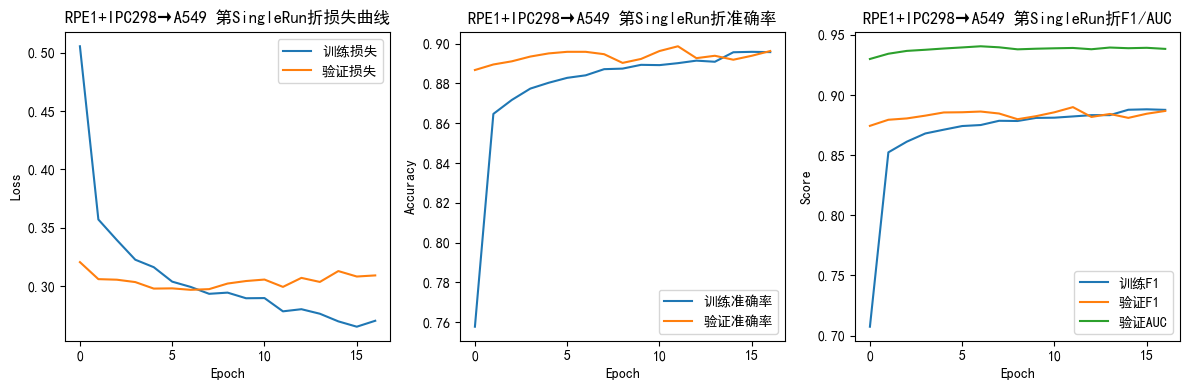


Final Result: 
Loss: 0.4461  Accuracy: 0.8164
AUC: 0.5865  Precision: 0.1341  Recall: 0.2639
F1: 0.1779  BACC: 0.5626


In [23]:
result = cross_cellline_eval(
    train_cells=['RPE1', 'IPC298'],
    test_cell='A549',
    df=sl_filtered
)

# 绘制训练曲线
plot_training_curves(result['train_history'], 'RPE1+IPC298→A549', 'SingleRun')

# 获取测试结果
print("\nFinal Result: ")
print(f"Loss: {result['test_metrics']['loss']:.4f}  Accuracy: {result['test_metrics']['acc']:.4f}")
print(f"AUC: {result['test_metrics']['auc']:.4f}  Precision: {result['test_metrics']['precision']:.4f}  Recall: {result['test_metrics']['recall']:.4f}")
print(f"F1: {result['test_metrics']['f1']:.4f}  BACC: {result['test_metrics']['bacc']:.4f}")